# QUESTION 2 :

In [2]:
import numpy as np
import matplotlib.pyplot as plt

lamda = 10

def phi(A,x):
  return  - np.sum(np.log(lamda- A@x))

def f(Q,p,x):
  return (x.T @ Q @ x + p.T@x)

def g(t,Q,A,p,x):

  return t*f(Q,p,x) + phi(A,x)

# Note : 
We implement the cholesky inversion for it being numericaly more stable.

When back tracking we have to make sure that we stay inside the domain of our function, otherwise we reduce our step size


In [3]:

def gradient(x, Q, p, A, t):
    h = 1. / (lamda - A @ x)

    return t * (2 * Q @ x + p) + A.T @ h

def hessian(x, Q, p, A, t):
    h = 1. / (lamda- A @ x)
    h = h.reshape(-1)
    return 2 * t * Q + A.T @ np.diag(h)**2 @ A


def cholesky_inv(X):
  # Cholesky decomposition inversion:
  c = np.linalg.inv(np.linalg.cholesky(X))
  inverse = np.dot(c.T,c)
  return inverse

In [40]:
def backtrack(t,Q,A,p,x,grad,newton_step):
  
  step =1 
  alpha = 0.4
  beta = 0.8

  while ((lamda - A@ (x + step*newton_step)) <0).any() or g(t,Q,A,p,x + step * newton_step ) > (g(t,Q,A,p,x) + alpha * step * grad.T @ newton_step):

    step *= beta

  assert ((lamda - A@ (x + step*newton_step)) >0).all()

  return step



def centering_step(t,Q,A,p,x,eps):

  pt_history= []

  while True:
      
    grad=gradient(x, Q, p, A, t)
    hess = hessian(x, Q, p, A, t)

    inv_hess = cholesky_inv(hess)

    newton_dec = grad.T @ inv_hess @ grad

    if newton_dec/2 < eps :
      break
    
    newton_step = - inv_hess @ grad
      
    step_size = backtrack(t,Q,A,p,x,grad,newton_step)

    pt_history.append(x)

    x = x + step_size * newton_step

  
  return pt_history
  

In [41]:
def barrier_method(Q,p,A,x,eps,u):
  
  t=1

  d = A.shape[0] ## number of constraints

  whole_path = []
  
  while ( (d/t) > eps):

    path = centering_step(t,Q,A,p,x,eps)

    whole_path += path
    x = path[-1]
    t = u*t

  return whole_path


# Question 3

Remark : Due to some unknown numerical issues we could not take our epsilon below 1e-14.

Answer : From the plot below we see that a $\mu=2$ takes 35  backtracking steps to converge. A choice of $\mu=50$ seems wise as it takes 10 steps to converge to optimal value.

u= 2
u= 15
u= 50
u= 100
u= 1000


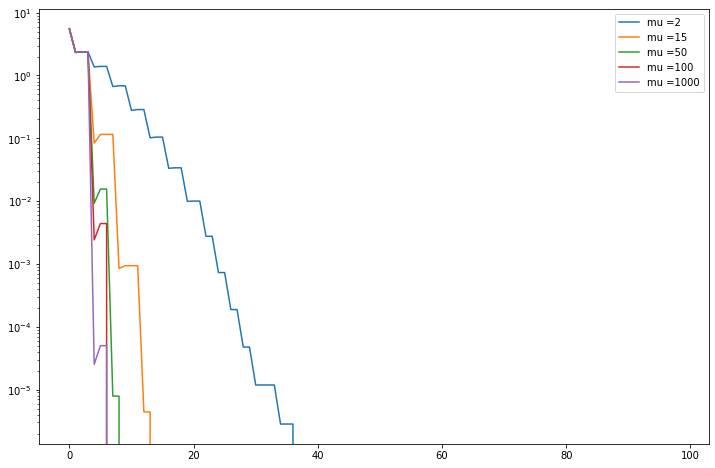

In [46]:
def get_sample(n=10,d=100):
    
    X =  np.random.randn(n, d)
    y =  np.random.randn(n).reshape(-1,1)

    Q = np.eye(n) / 2
    p = - y

    A = np.concatenate((X.T, - X.T), axis=0)

    x0 = np.zeros(n).reshape(-1,1)

    return Q,p,A,x0


us = [2,15,50,100,1000]

Q,p,A,x = get_sample()

eps = 1e-14


plt.figure(figsize=(12,8))
for u in us:
  print("u=",u)
  path=barrier_method(Q,p,A,x,eps,u=u)
  ys = [np.squeeze(f(Q,p,x)) for x in path]
  plt.semilogy(ys-ys[-1],label='mu ='+str(u))

plt.legend()
plt.show()